In [16]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
import anomaly

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Input, TimeDistributed, Dense
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# 학습된 모델을 사용하여 데이터 재구성
class Evaluation_Metrics:
    def __init__(self, data, predict_data, now_position, after_position):
        self.data = data
        self.predict_data = predict_data
        self.now_position = now_position
        self.after_position = after_position
        
    def rmse(self):
        self._rmse = np.mean(np.square(self.data[:,self.now_position,:] - self.predict_data[:,self.after_position-1,:]))
        return self._rmse
    
    def mae(self):
        self._mae = np.mean(abs(self.data[:,self.now_position,:] - self.predict_data[:,self.after_position-1,:]))
        return self._mae
    
    def plot(self):
        plt.figure(figsize=(15, 8))
        plt.plot(self.data[:,self.now_position,:].flatten(), label='Original Data')
        plt.plot(self.predict_data[:,self.after_position- 1,:].flatten(), label='Reconstructed Data')
        plt.legend()
        plt.show()

In [3]:
ori_path = '../5. Dataset_combine/'
csv_list = os.listdir(ori_path + '3. csv/')
plot_list = os.listdir(ori_path + '2. Plot/')
motor_list = list(set(map(lambda x: x.split('_')[1],csv_list)))
mul_label = pd.read_csv('../5. Dataset_combine/label_check.csv', encoding='cp949')

font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)
look_back = 5

### 5. LSTM-AuToEncoder
* 실제로는 고장보다는 정상만 있는 경우가 더 많다
* 정상만 있는 데이터들을 AutoEncoder를 이용하여 정상 데이터를 만든 뒤 비교한다
* 모든 데이터를 합쳐 만들기에는 범위가 다양하기 때문에 따로 볼 필요가 있음

In [4]:
# 정상인 데이터만 있는 것들을 가져오기
a = [x for x in csv_list if '베어링불량' in x]
a_ = list(map(lambda x: x.split('_')[1],a))
b = [x for x in csv_list if '회전체불평형' in x]
b_ = list(map(lambda x: x.split('_')[1],b))
c =[x for x in csv_list if '축정렬불량' in x]
c_ = list(map(lambda x: x.split('_')[1],c))
d= [x for x in csv_list if '벨트느슨함' in x]
d_ = list(map(lambda x: x.split('_')[1],d))

multi_motor = sorted(list(set(a_ + b_ + c_ + d_)) )
only_normal_motor = [x for x in motor_list if x not in multi_motor]

motor_name = [x for x in csv_list if multi_motor[4] in x]
motor_name

['3.7kW_L-EF-02_베어링불량.csv', '3.7kW_L-EF-02_정상.csv']

In [5]:
# 'L-CAHU-03R'
df_normal = pd.read_csv(ori_path + '3. csv/' + motor_name[0])
df_err = pd.read_csv(ori_path + '3. csv/' + motor_name[1])

C:\Users\chzhf\anaconda3\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


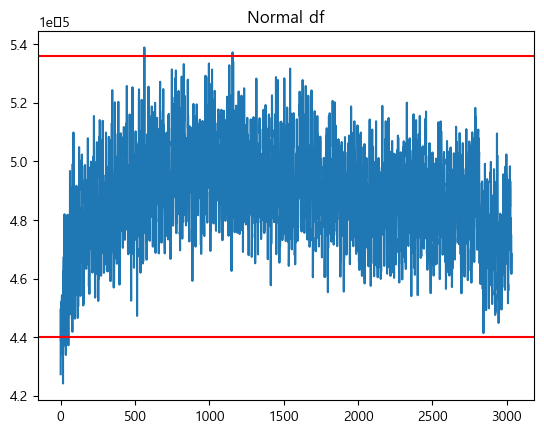

In [6]:
# 3sigma 기준 삭제
plt.plot(df_normal['Var'])
plt.axhline(df_normal['Var'].mean() + df_normal['Var'].std()*3, color = 'red')
plt.axhline(df_normal['Var'].mean() - df_normal['Var'].std()*3, color = 'red')
plt.title('Normal df')
plt.show()

In [7]:
Mean = df_normal['Var'].mean()
Std = df_normal['Var'].std()

upper = Mean + 3 * Std
lower = Mean - 3 * Std

clean_df = df_normal['Var'][(df_normal['Var'] < upper) & (df_normal['Var'] > lower)]
clean_df = clean_df.reset_index(drop = True)
clean_data = clean_df.values
clean_df.shape

(3020,)

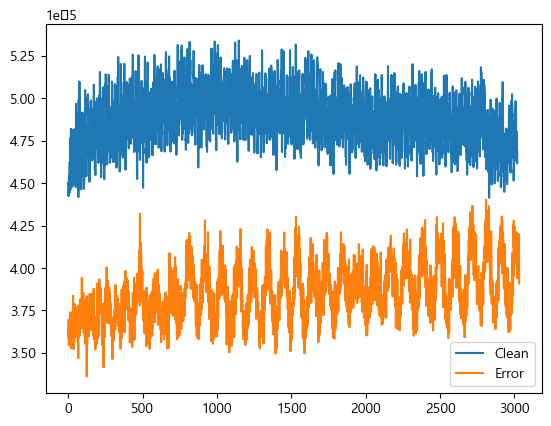

In [8]:
# plt.subplot(2,1,1)
plt.plot(clean_df, label = 'Clean')
plt.plot(df_err['Var'], label = 'Error')
plt.legend()
plt.show()


In [35]:
def Dpreprocessing(Data, look_back = 5):
    # loook_back 5
    x_values = []
    y_values = []
    for i in range(len(Data) - look_back):
        x_values.append(Data[i:(i+look_back)])
        y_values.append(Data[i+look_back])
    return np.array(x_values), np.array(y_values)

In [23]:
clean_data

array([4.49634695e-05, 4.50267072e-05, 4.42362026e-05, ...,
       4.66057503e-05, 4.61574670e-05, 4.68330375e-05])

In [30]:
scaler = StandardScaler()
clean_data = clean_data.reshape(-1,1)
scaler.fit(clean_data)

clean_data = scaler.transform(clean_data)
test_data = df_err['Var'].values.reshape(-1,1)
test_data = scaler.transform(test_data)

In [36]:
train_X, train_Y = Dpreprocessing(clean_data, look_back)
test_X, test_Y = Dpreprocessing(test_data, look_back)

In [41]:
train_X.shape

(3015, 5, 1)

In [61]:
lenth = int(len(train_X)*0.3)

train_dX = train_X[lenth:]
train_dY = train_Y[lenth:]
val_dX = train_X[-lenth:]
val_dY = train_Y[-lenth:]

In [63]:
train_dX.shape, train_dY.shape, val_dX.shape, val_dY.shape

((2111, 5, 1), (2111, 1), (904, 5, 1), (904, 1))

In [64]:
val_dX.shape

(904, 5, 1)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm_18 (LSTM)              (None, 5, 128)            66560     
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                                 
 lstm_20 (LSTM)              (None, 5, 64)             33024     
                                                                 
 time_distributed_5 (TimeDis  (None, 5, 1)             65        
 tributed)                                                 

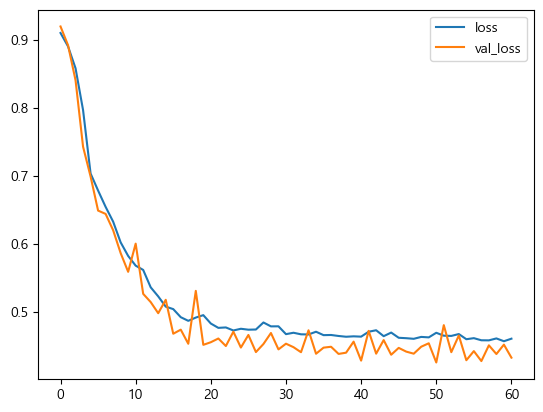

In [65]:
# clean data로 학습
# 하이퍼파라미터 설정
input_size = 1
hidden_size = 64
num_layers = 2
num_epochs = 100
learning_rate = 0.001
look_back = 5

train_data.shape # [5967, 5, 1]
 

# LSTM Autoencoder 모델 정의
input_layer = Input(shape=(train_data.shape[1], train_data.shape[2]))

encoder = LSTM(128, activation='relu',return_sequences = True)(input_layer)
eh1 = LSTM(64, activation='relu', return_sequences = False)(encoder)
latent_space = RepeatVector(look_back)(eh1)

decoder = LSTM(64, activation='relu', return_sequences=True)(latent_space)
dh1 = LSTM(64, activation='relu', return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(train_data.shape[2]))(decoder)

# 모델 초기화
model = Model(input_layer, output_layer)

# 손실 함수와 최적화 함수 정의
model.compile(optimizer='adam', loss='mse')#
model.summary()
# 모델 학습
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

hitory = model.fit(x = train_dX, y = train_dY, 
                   validation_data = (val_dX,val_dY),
                   epochs=num_epochs, batch_size=512, verbose = 0
                   , callbacks= [early_stopping])
    
histo = hitory.history
plt.plot(histo['loss'], label = 'loss')
plt.plot(histo['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

95/95 [==============================] - 0s 4ms/step
mae normal 0.7945773444341481 err 9.02790502233267
mae normal 0.9121998252103468 err 91.3476603064011


C:\Users\chzhf\anaconda3\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


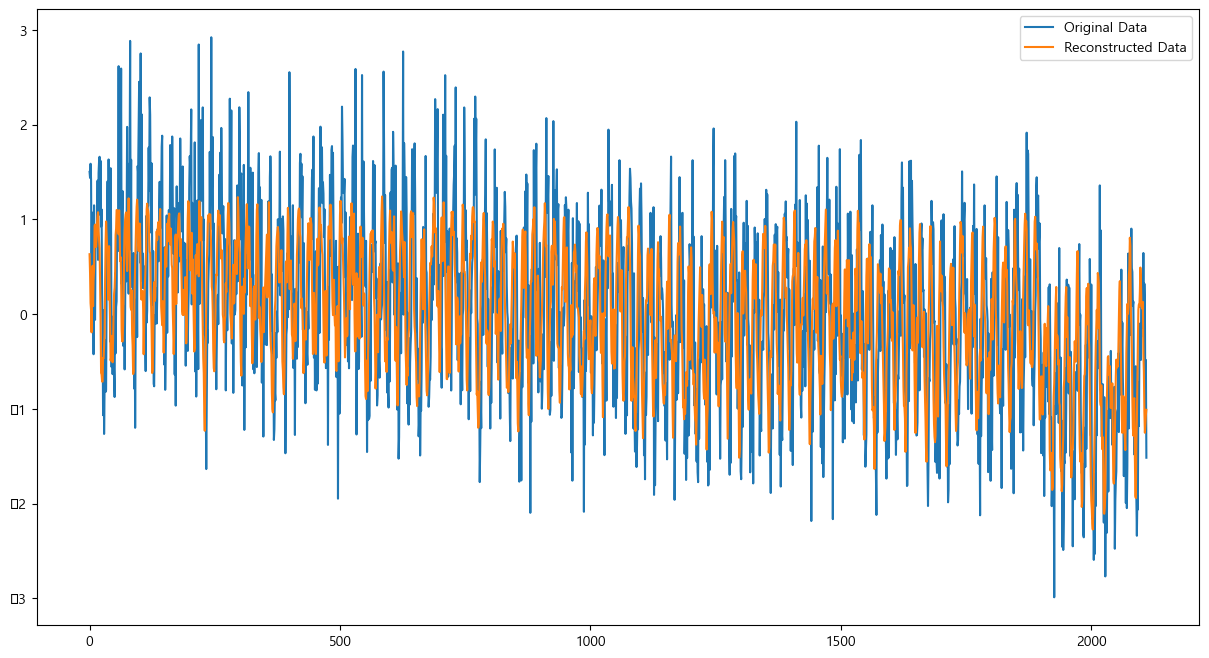

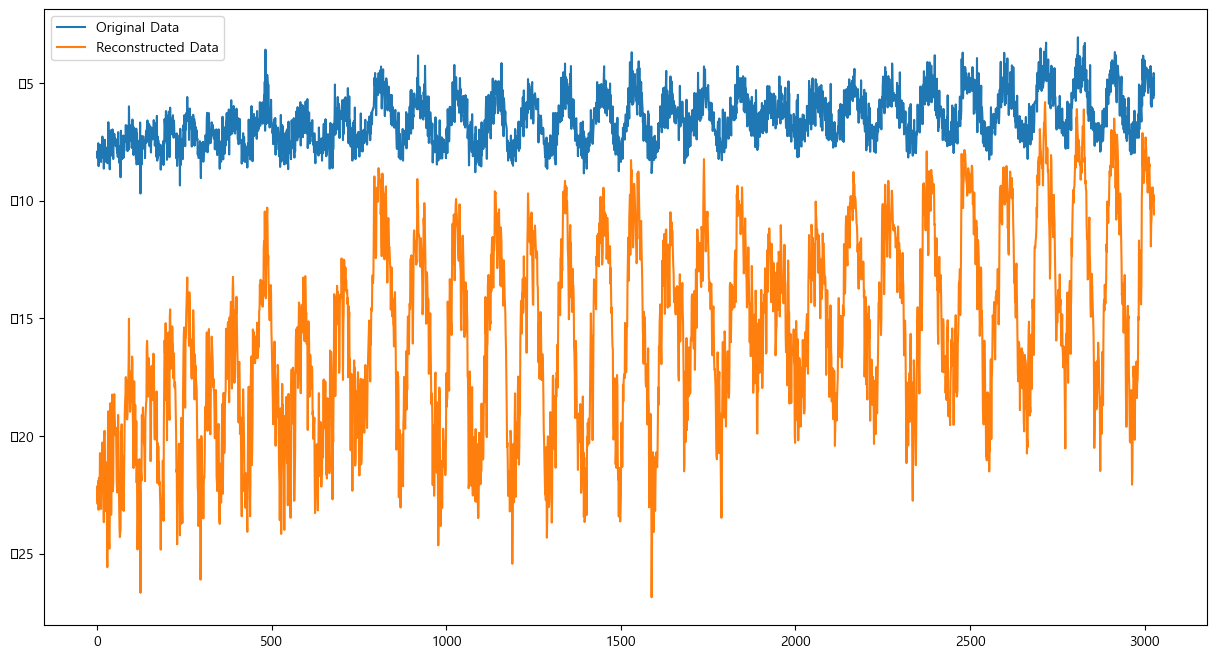

In [66]:
# train data
now = 0
want = 5 # 5초 뒤 예측
# 실제값

reconstructed_data = model.predict(train_dX)
eval_train = Evaluation_Metrics(train_dX, reconstructed_data, now, want)

# 예측값 - 실제 vs 고장
pred_test = model.predict(test_X)
eval_test = Evaluation_Metrics(test_X, pred_test, now, want)


print("mae", "normal", eval_train.mae(), "err", eval_test.mae())
print("mae", "normal", eval_train.rmse(), "err", eval_test.rmse())
eval_train.plot()
eval_test.plot()